Her har jeg defineret udtrykkene for $g$ for de forskellige objekter, samt to funktioner der bruges til at beregne usikkerheden på $g$ vha. ophobningsloven.

In [472]:
import sympy as sp
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

# Udtryk for g for de forskellige former
a, R, r, theta = sp.symbols('a R r theta')

g_solid_kugle_expr = -(a*(1+(2 * R**2 /( 5 * r**2))))/sp.cos(theta)

g_hul_kugle_expr = -(a*(1+(2 * R**2 /( 3 * r**2))))/sp.cos(theta)

g_hul_cylinder_expr = -(a*(1+(R**2 / r**2)))/sp.cos(theta)

# En funktion der returnerer en liste med de partielle afledede af et udtryk for g
def partial_derivatives(expr):
    return [(sp.diff(expr, var), var) for var in [a, R, r, theta]]

# Brug ophobningsloven til at finde udtrykket for usikkerheden på g for et givent udtryk
# Tager et udtryk for g, en liste med usikkerheder og en liste med parametre som input
def ophobningslov(expr, uncertainties, parameters):
    partials = partial_derivatives(expr)
    expr = sp.sqrt(sum([(partials[i][0] * uncertainties[i])**2 for i in range(len(partials))]))
    expr = expr.subs({a: parameters[0], R: parameters[1], r: parameters[2], theta: parameters[3]})
    return expr




Dette stykke kode indlæser vores data og finder peaks i dem.

In [473]:
# Filstier
solid_kugle_1_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 11 - skråplan 2\data\solid kugle nr 1.csv"
hul_kugle_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 11 - skråplan 2\data\hul kugle nr 1.csv"
hul_cylinder_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 11 - skråplan 2\data\cylinder nr 1.csv"

# Indlæs data fra csv-fil
solid_kugle_1 = np.genfromtxt(solid_kugle_1_loc, delimiter=",", skip_header=1)
solid_kugle_t_arr = solid_kugle_1[:, 0]
solid_kugle_v_arr = solid_kugle_1[:, 1]

hul_kugle = np.genfromtxt(hul_kugle_loc, delimiter=",", skip_header=1)
hul_kugle_t_arr = hul_kugle[:, 0]
hul_kugle_v_arr = hul_kugle[:, 1]

hul_cylinder = np.genfromtxt(hul_cylinder_loc, delimiter=",", skip_header=1)
hul_cylinder_t_arr = hul_cylinder[:, 0]
hul_cylinder_v_arr = hul_cylinder[:, 1]

# Returnerer tiderne knyttet til de første punkter over en given voltgrænse
def find_peaks(time_arr, voltage_arr, V_limit):
    peaks = []
    # For hvert peak finder vi det første punkt over en voltgrænse
    for i in range(len(voltage_arr)):
        # Tjek om punktet er over grænsen
        if voltage_arr[i] > V_limit:
            # Hvis det forrige punkt er under grænsen i det første punkt over grænsen for et givent peak
            if voltage_arr[i - 1] < V_limit:
                peaks.append(time_arr[i])

    return peaks

# Find tiderne for de forskellige kugler
peaks_solid_kugle = find_peaks(solid_kugle_t_arr, solid_kugle_v_arr, 3)
peaks_hul_kugle = find_peaks(hul_kugle_t_arr, hul_kugle_v_arr, 3)
peaks_hul_cylinder = find_peaks(hul_cylinder_t_arr, hul_cylinder_v_arr, 3)

print(peaks_solid_kugle)



[0.001291566265060218, 0.2397915662650603, 0.4172915662650603, 0.5532915662650603, 0.6797915662650602]


Her har jeg skrevet nogle af vores variable ind (med usikkerhed). Accelerationerne og deres usikkerheder kommer først længere nede, da de skal findes ud fra fitsne.

In [474]:
# Tid
t_u = 0.00025 # Sekunder

# Radius
R_u = 0.05 * 10**(-3) # Meter

R_solid_kugle = 5.10 * 10**(-3) # Meter

R_hul_kugle = 5.05 * 10**(-3) # Meter

R_hul_cylinder = 16.0 * 10**(-3) # Meter

# Omdrejningsradius
r_u = 0.05 * 10**(-3) # Meter

r_solid_kugle = 5.025 * 10**(-3) # Meter

r_hul_kugle = 4.80 * 10**(-3) # Meter

r_hul_cylinder = 16.0 * 10**(-3) # Meter

# Afstand
d_u = 0.5 * 10**(-2) # Meter
dist_fotogates = [0.166, 0.176, 0.165, 0.177] # Meter

d = np.sum(dist_fotogates)/1 # Meter

# Vinklen mellem bunden af skråplanet og væggen bestemt ved A/B
A = 89.7 #cm
B = 22.1 #cm

# Her bruges ophobningsloven til at finde usikkerheden på vinklen ud fra usikkerheden på længdemålingerne
vinkel_u = np.sqrt(((B/(A**2 + B**2)) * d_u)**2 + ((-A/(A**2 + B**2)) * d_u)**2) # Radianer
vinkel = np.arctan(A/B) # Radianer


In [475]:
# Forberedelse til fits med stedfunktion (uden starthastighed)
# Funktionen der skal fittes
def stedfunk(t, a, v_0, s_0):
    s = a/2 * t**2 + v_0 * t + s_0
    return s
    
# Beregner den propagerede usikkerhed fra x-aksen til y-aksen (se stat. note 2.4) når parametrene fra fittet er fundet
# Usikkerheden på s er givet ved ds/dt * t_u
def prop_u(times, a, v_0, s_0):
    return np.array([abs(2*a*t + v_0)*t_u for t in times])

# Vi sætter afstanden til 0 ved den første fotogate
dist_fotogates = np.insert(dist_fotogates, 0, 0)

# Afstanden til de en given fotogate er summen af afstandene før
fit_dist = np.cumsum(dist_fotogates)

# curve_fit vil gerne have usikkerheder som arrays
t_u_arr = np.full(len(fit_dist), t_u)
d_u_arr = np.full(len(fit_dist), d_u)

Denne kæmpe blok kode laver stedfunktions-fits og plots til hvert forsøg.

Først laves et fit, så bruges værdien for $a$ fra det fit til at bestemme den propagerede usikkerhed fra usikkerheden fra tiden. 
Derefter laves et nyt fit med den samlede usikkerhed på længden (både med den del der kommer fra måleusikkerhed på længden og usikkerhed på tiden).

Til sidst plottes fittet og punkterne sammen og $g$ beregnes med formlerne fra teoriafsnittet i logbogen.

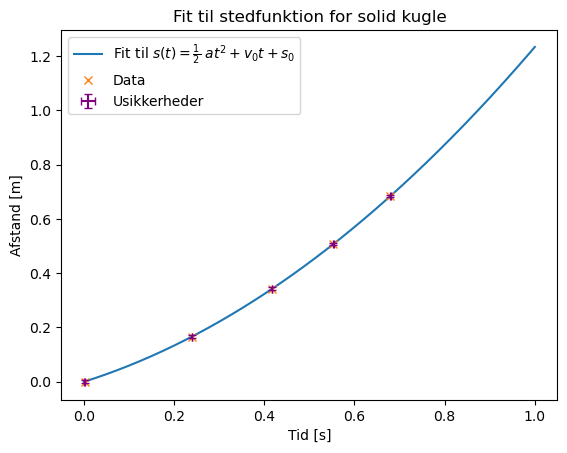

parametrene fra fittet [ 1.41773904e+00  5.25348724e-01 -6.92173056e-04]
g = -8.37


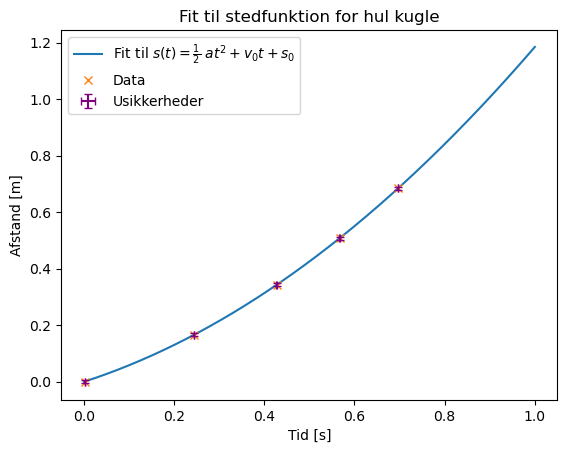

parametrene fra fittet [ 1.33566208e+00  5.17554053e-01 -8.65161068e-04]
g = -9.70


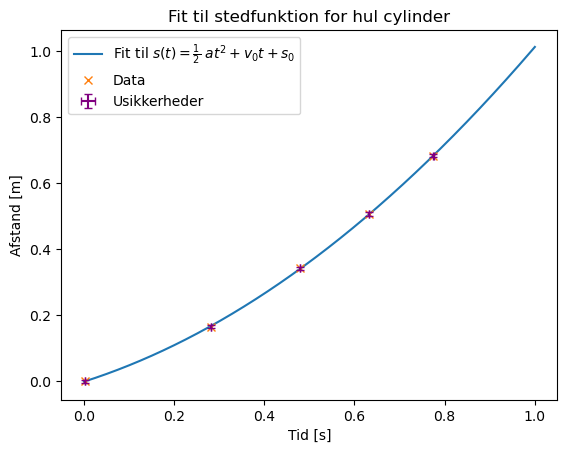

parametrene fra fittet [ 1.15710316e+00  4.36135913e-01 -1.07179934e-03]
g = -9.67


In [476]:
# Solid kugle
# Lav fittet
param_solid_kugle, cov_solid_kugle = curve_fit(stedfunk, peaks_solid_kugle, fit_dist, sigma=d_u_arr, absolute_sigma=True)

# Tilføj propageret usikkerhed fra t_u til s_u
solid_kugle_fit_sigma = np.sqrt(np.diagonal(cov_solid_kugle))
solid_kugle_t_u = np.sqrt(prop_u(peaks_solid_kugle, *param_solid_kugle)**2 + d_u_arr**2)

# Lav fittet igen med ny usikkerhed
param_solid_kugle, cov_solid_kugle = curve_fit(stedfunk, peaks_solid_kugle, fit_dist, sigma=d_u_arr, absolute_sigma=True)

# Beregn usikkerhed igen
solid_kugle_fit_sigma = np.sqrt(np.diagonal(cov_solid_kugle))

# Plot fit 
X = np.linspace(0, 1, 1000)
Y = stedfunk(X, *param_solid_kugle)

plt.figure(1)
plt.title("Fit til stedfunktion for solid kugle")
plt.xlabel("Tid [s]")
plt.ylabel("Afstand [m]")

plt.plot(X, Y, label=r"Fit til $s(t) = \frac{1}{2} \; a  t^2 + v_0 t + s_0$")
plt.plot(peaks_solid_kugle, fit_dist, "x", label="Data")

plt.errorbar(peaks_solid_kugle, fit_dist, xerr=t_u_arr, yerr=d_u_arr, capsize=3, color="purple", fmt="none", label="Usikkerheder")
plt.legend()
plt.show()

print("parametrene fra fittet", param_solid_kugle)

# Beregn g med usikkerhed
g_solid_kugle = g_solid_kugle_expr.subs({a: param_solid_kugle[0], r: r_solid_kugle, R: R_solid_kugle, theta: vinkel})

print("g = {:.2f}".format(g_solid_kugle))

# Hul kugle
# Lav fittet
param_hul_kugle, cov_hul_kugle = curve_fit(stedfunk, peaks_hul_kugle, fit_dist, sigma=d_u_arr, absolute_sigma=True)

# Tilføj propageret usikkerhed fra t_u til s_u

hul_kugle_fit_sigma = np.sqrt(np.diagonal(cov_hul_kugle))
hul_kugle_t_u = np.sqrt(prop_u(peaks_hul_kugle, *param_hul_kugle)**2 + d_u_arr**2)

# Lav fittet igen med ny usikkerhed
param_hul_kugle, cov_hul_kugle = curve_fit(stedfunk, peaks_hul_kugle, fit_dist, sigma=d_u_arr, absolute_sigma=True)

# Beregn usikkerhed igen
hul_kugle_fit_sigma = np.sqrt(np.diagonal(cov_hul_kugle))

# Plot fit
X = np.linspace(0, 1, 1000)
Y = stedfunk(X, *param_hul_kugle)

plt.figure(2)
plt.title("Fit til stedfunktion for hul kugle")
plt.xlabel("Tid [s]")
plt.ylabel("Afstand [m]")
plt.plot(X, Y, label=r"Fit til $s(t) = \frac{1}{2} \; a  t^2 + v_0 t + s_0$")
plt.plot(peaks_hul_kugle, fit_dist, "x", label="Data")

plt.errorbar(peaks_hul_kugle, fit_dist, xerr=t_u_arr, yerr=d_u_arr, capsize=3, color="purple", fmt="none", label="Usikkerheder")
plt.legend()
plt.show()

print("parametrene fra fittet", param_hul_kugle)

g_hul_kugle = g_hul_kugle_expr.subs({a: param_hul_kugle[0], r: r_hul_kugle, R: R_hul_kugle, theta: vinkel})

print("g = {:.2f}".format(g_hul_kugle))

# Hul cylinder
# Lav fittet
param_hul_cylinder, cov_hul_cylinder = curve_fit(stedfunk, peaks_hul_cylinder, fit_dist, sigma=d_u_arr, absolute_sigma=True)

# Tilføj propageret usikkerhed fra t_u til s_u
hul_cylinder_fit_sigma = np.sqrt(np.diagonal(cov_hul_cylinder))
hul_cylinder_t_u = np.sqrt(prop_u(peaks_hul_cylinder, *param_hul_cylinder)**2 + d_u_arr**2)

# Lav fittet igen med ny usikkerhed
param_hul_cylinder, cov_hul_cylinder = curve_fit(stedfunk, peaks_hul_cylinder, fit_dist, sigma=d_u_arr, absolute_sigma=True)

# Beregn usikkerhed igen
hul_cylinder_fit_sigma = np.sqrt(np.diagonal(cov_hul_cylinder))

# Plot fit
X = np.linspace(0, 1, 1000)
Y = stedfunk(X, *param_hul_cylinder)

plt.figure(3)
plt.title("Fit til stedfunktion for hul cylinder")
plt.xlabel("Tid [s]")
plt.ylabel("Afstand [m]")
plt.plot(X, Y, label=r"Fit til $s(t) = \frac{1}{2} \; a  t^2 + v_0 t + s_0$")
plt.plot(peaks_hul_cylinder, fit_dist, "x", label="Data")

plt.errorbar(peaks_hul_cylinder, fit_dist, xerr=t_u_arr, yerr=d_u_arr, capsize=3, color="purple", fmt="none", label="Usikkerheder")
plt.legend()
plt.show()

print("parametrene fra fittet", param_hul_cylinder)

g_hul_cylinder = g_hul_cylinder_expr.subs({a: param_hul_cylinder[0], r: r_hul_cylinder, R: R_hul_cylinder, theta: vinkel})

print("g = {:.2f}".format(g_hul_cylinder))




Her beregner vi usikkerheden på $g$ og viser vores resultater. Usikkerheder er afrundet til første decimal (med {:.0e}) og de betydende cifre for de andre tal er bestemt ud fra sidste ciffer på hver usikkerhed.

In [477]:
# Acceleration med usikkerhed
a_solid_kugle = param_solid_kugle[0] # Skal tages fra fit til stedfunktion
a_u_solid_kugle = solid_kugle_fit_sigma[0] # Skal tages fra fit til stedfunktion

a_hul_kugle = param_hul_kugle[0] # Skal tages fra fit til stedfunktion
a_u_hul_kugle = hul_kugle_fit_sigma[0] # Skal tages fra fit til stedfunktion

a_hul_cylinder = param_hul_cylinder[0] # Skal tages fra fit til stedfunktion
a_u_hul_cylinder = hul_cylinder_fit_sigma[0] # Skal tages fra fit til stedfunktion

# Beregj usikkerheden på g for de forskellige former
g_u_solid_kugle = ophobningslov(g_solid_kugle_expr, [a_u_solid_kugle, R_u, r_u, vinkel_u], [a_solid_kugle, R_solid_kugle, r_solid_kugle, vinkel])
g_u_hul_kugle = ophobningslov(g_hul_kugle_expr, [a_u_hul_kugle, R_u, r_u, vinkel_u], [a_hul_kugle, R_solid_kugle, r_solid_kugle, vinkel])
g_u_hul_cylinder = ophobningslov(g_hul_cylinder_expr, [a_u_hul_cylinder, R_u, r_u, vinkel_u], [a_hul_cylinder, R_solid_kugle, r_solid_kugle, vinkel])

# Vis resultaterne 
display(md(r"**Resultater:**"))
display(md(r"**Solid kugle:**"))
display(md(r"Acceleration: $a = ({:.2f} \pm {:.0e}) \; \mathrm{{m/s^2}}$".format(a_solid_kugle, a_u_solid_kugle)))
display(md(r"Tyngdeacceleration: $g = ({:.1f} \pm {:.0e}) \; \mathrm{{m/s^2}}$".format(g_solid_kugle, g_u_solid_kugle)))
display(md(r"**Hul kugle:**"))
display(md(r"Acceleration: $a = ({:.2f} \pm {:.0e}) \; \mathrm{{m/s^2}}$".format(a_hul_kugle, a_u_hul_kugle)))
display(md(r"Tyngdeacceleration: $g = ({:.1f} \pm {:.0e}) \; \mathrm{{m/s^2}}$".format(g_hul_kugle, g_u_hul_kugle)))
display(md(r"**Hul cylinder:**"))
display(md(r"Acceleration: $a = ({:.2f} \pm {:.0e}) \; \mathrm{{m/s^2}}$".format(a_hul_cylinder, a_u_hul_cylinder)))
display(md(r"Tyngdeacceleration: $g = ({:.1f} \pm {:.0e}) \; \mathrm{{m/s^2}}$".format(g_hul_cylinder, g_u_hul_cylinder)))




**Resultater:**

**Solid kugle:**

Acceleration: $a = (1.42 \pm 9e-02) \; \mathrm{m/s^2}$

Tyngdeacceleration: $g = (-8.4 \pm 6e-1) \; \mathrm{m/s^2}$

**Hul kugle:**

Acceleration: $a = (1.34 \pm 9e-02) \; \mathrm{m/s^2}$

Tyngdeacceleration: $g = (-9.7 \pm 6e-1) \; \mathrm{m/s^2}$

**Hul cylinder:**

Acceleration: $a = (1.16 \pm 7e-02) \; \mathrm{m/s^2}$

Tyngdeacceleration: $g = (-9.7 \pm 6e-1) \; \mathrm{m/s^2}$